In [153]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import matplotlib.pyplot as plt
%matplotlib inline  

In [157]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
# sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [158]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [193]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBBBSB'
meas='PRCP'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
3764
+-------------------+-----------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|          coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-----------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
| -77.26056082660727|74.77142532821838|16.338019841650176|    661.4|SBBBBBSB| 48.3475|-101.9325|       PRCP|0.9830368284532149|0.9671490688342597|0.9663905084119726|0.8956851418860386|USC00328627| 39

In [194]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT elevation, vector, station, latitude, longitude, year FROM weather\n\tWHERE measurement='%s'"%(meas)
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(5)
df1=df1.rdd.map(lambda row:[np.nanmean(unpackArray(row['vector'],np.float16)), row['elevation'],row['station'],row['latitude'],row['longitude'], row['year']])
rows=df1.collect()
print (len(rows), len(rows[0]))

SELECT elevation, vector, station, latitude, longitude, year FROM weather
	WHERE measurement='PRCP'
3764 rows
+---------+--------------------+-----------+--------+---------+------+
|elevation|              vector|    station|latitude|longitude|  year|
+---------+--------------------+-----------+--------+---------+------+
|    661.4|[80 4F 00 00 00 4...|USC00328627| 48.3475|-101.9325|1996.0|
|    374.0|[00 00 00 00 00 0...|CA005010640|   49.55|   -99.08|1965.0|
|    503.0|[80 4D 00 00 00 0...|CA005012941|    49.3|  -100.32|1995.0|
|    507.5|[00 00 00 00 00 0...|USW00024013| 48.2553|-101.2733|2002.0|
|    442.0|[00 00 00 00 00 0...|CA005010180|   49.37|  -100.93|1974.0|
+---------+--------------------+-----------+--------+---------+------+
only showing top 5 rows

(3764, 6)


In [195]:
pd_df = pd.DataFrame(rows, columns=['vector', 'elevation', 'station','latitude','longitude', 'year'])

In [196]:
pd_df

,vector,elevation,station,latitude,longitude,year
0,9.601562,661.4,USC00328627,48.3475,-101.9325,1996.0
1,13.812500,374.0,CA005010640,49.5500,-99.0800,1965.0
2,13.664062,503.0,CA005012941,49.3000,-100.3200,1995.0
3,7.890625,507.5,USW00024013,48.2553,-101.2733,2002.0
4,12.062500,442.0,CA005010180,49.3700,-100.9300,1974.0
5,11.039062,609.9,USC00322385,48.8333,-100.0333,1950.0
6,16.390625,403.0,CA005012545,49.4500,-99.0200,1991.0
7,12.578125,467.9,USC00328990,48.0797,-100.8750,2003.0
8,19.578125,373.0,CA005012672,49.7830,-99.6330,1955.0
9,9.460938,507.5,USW00024013,48.2553,-101.2733,2003.0


In [197]:
pd_df = pd_df.replace([np.inf, -np.inf], np.NaN)

In [198]:
# Fix the inf....

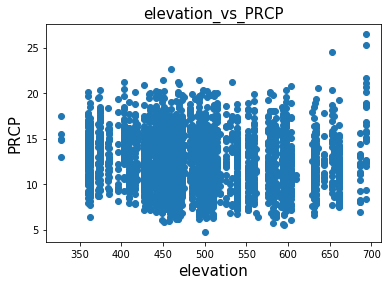

In [199]:
plt.title('elevation_vs_' + meas, fontsize=15)
plt.xlabel('elevation', fontsize=15)
plt.ylabel(meas, fontsize=15)
plt.scatter(pd_df['elevation'], pd_df['vector'])
plt.savefig('result_plots/elevation_vs_' + meas)

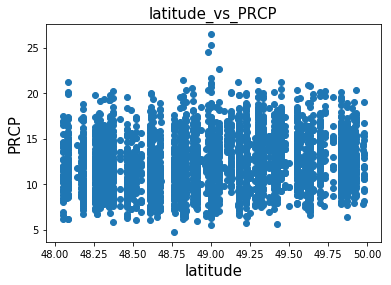

In [200]:
plt.title('latitude_vs_' + meas, fontsize=15)
plt.xlabel('latitude', fontsize=15)
plt.ylabel(meas, fontsize=15)
plt.scatter(pd_df['latitude'], pd_df['vector'])
plt.savefig('result_plots/latitude_vs_' + meas)

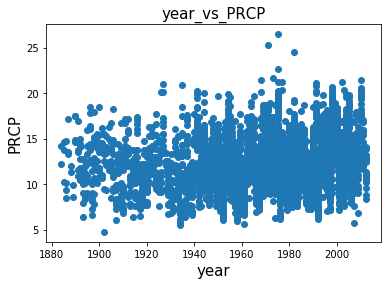

In [201]:
plt.title('year_vs_' + meas, fontsize=15)
plt.xlabel('year', fontsize=15)
plt.ylabel(meas, fontsize=15)
plt.scatter(pd_df['year'], pd_df['vector'])
plt.savefig('result_plots/year_vs_' + meas)

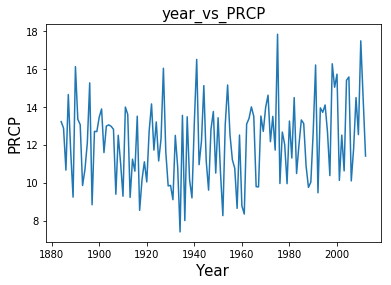

In [202]:
vals = pd_df.groupby(['year'])['vector'].mean()
plt.title('year_vs_' + meas, fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel(meas, fontsize=15)
plt.plot(vals.index, vals)
plt.savefig('result_plots/year_vs_' + meas)

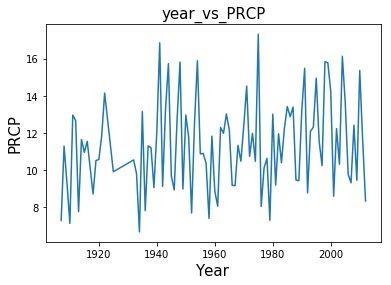

In [203]:
vals = pd_df[pd_df['station'].isin(['USC00329333', 'USC00323686', 'CA00501A7AR', 'CA005012719'])].groupby(['year'])['vector'].mean()
plt.title('year_vs_' + meas, fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel(meas, fontsize=15)
plt.plot(vals.index, vals)
# plt.savefig('result_plots/year_vs_' + meas)

In [118]:
# Global warming in p-value

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [120]:
pd_df[pd_df['station'].isin(['USC00329333'])]

,vector,elevation,station,latitude,longitude,year
1,133.3750,457.8,USC00329333,48.9097,-101.0192,1960.0
77,132.2500,457.8,USC00329333,48.9097,-101.0192,1968.0
116,127.7500,457.8,USC00329333,48.9097,-101.0192,1992.0
121,137.2500,457.8,USC00329333,48.9097,-101.0192,2008.0
144,133.6250,457.8,USC00329333,48.9097,-101.0192,2010.0
147,120.5625,457.8,USC00329333,48.9097,-101.0192,1954.0
169,134.1250,457.8,USC00329333,48.9097,-101.0192,2006.0
177,134.1250,457.8,USC00329333,48.9097,-101.0192,1922.0
179,131.3750,457.8,USC00329333,48.9097,-101.0192,1966.0
189,119.3750,457.8,USC00329333,48.9097,-101.0192,1945.0
